# Exercise 3 - part A: eQTL analysis | Data preparation
### Chosen datasets: ```Blood stem cell (GSE18067)```, ```Erythroid (GSE18067)```
### Chosen phenotype: `Infectious disease, immune function: H5N1 influenza A virus mortality rate 30 days after infection (Boon-Webby Trait 1) [% death]`

#### Written by: Shani Soustiel, id 316315720 and Shir Tova Segev, id 207353822

Importing the necessary libraries

In [1]:
import GEOparse
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle

CELL_TYPE = "Erythroid"  # Erythroid, Stem

Loading the data

In [2]:
gse = GEOparse.get_GEO(geo="GSE18067", destdir="./data")    # what expression value the genes have
blood_annot = pd.read_csv("./data/annotation.csv", sep="\t")    # what genes to consider
pd_meta = pd.read_table("./data/MGI_Coordinates.Build37.rpt.txt")   # where genes are located
genotypes = pd.read_excel("./data/genotypes.xls", index_col=0, header=1)

25-Sep-2024 17:44:50 DEBUG utils - Directory ./data already exists. Skipping.
25-Sep-2024 17:44:50 INFO GEOparse - File already exist: using local version.
25-Sep-2024 17:44:50 INFO GEOparse - Parsing ./data/GSE18067_family.soft.gz: 
25-Sep-2024 17:44:50 DEBUG GEOparse - DATABASE: GeoMiame
25-Sep-2024 17:44:50 DEBUG GEOparse - SERIES: GSE18067
25-Sep-2024 17:44:50 DEBUG GEOparse - PLATFORM: GPL6238
25-Sep-2024 17:44:51 DEBUG GEOparse - SAMPLE: GSM451699
25-Sep-2024 17:44:51 DEBUG GEOparse - SAMPLE: GSM451700
25-Sep-2024 17:44:51 DEBUG GEOparse - SAMPLE: GSM451701
25-Sep-2024 17:44:52 DEBUG GEOparse - SAMPLE: GSM451702
25-Sep-2024 17:44:52 DEBUG GEOparse - SAMPLE: GSM451703
25-Sep-2024 17:44:52 DEBUG GEOparse - SAMPLE: GSM451704
25-Sep-2024 17:44:52 DEBUG GEOparse - SAMPLE: GSM451705
25-Sep-2024 17:44:52 DEBUG GEOparse - SAMPLE: GSM451706
25-Sep-2024 17:44:52 DEBUG GEOparse - SAMPLE: GSM451707
25-Sep-2024 17:44:53 DEBUG GEOparse - SAMPLE: GSM451708
25-Sep-2024 17:44:53 DEBUG GEOparse - 

parse GSE data

In [3]:
def parse_gse(raw_gse):
    """
    gets GSE data, and parses it into a Dataframe.
    """

    final_df = pd.DataFrame(columns=["GSM_name", "ID_REF", "VALUE"])
    sample_dfs = []

    # Iterate through each sample
    for gsm_name, gsm in raw_gse.gsms.items():
        sample_data = {
            "GSM_name": gsm_name,
            "ID_REF": gsm.table["ID_REF"],
            "VALUE": gsm.table["VALUE"],
        }
        sample_df = pd.DataFrame(sample_data)
        sample_dfs.append(sample_df)

    gse_df = pd.concat(sample_dfs, ignore_index=True)
    gse_df.set_index("GSM_name", inplace=True)
    gene_identifiers = pd.DataFrame(gse.gpls[list(gse.gpls.keys())[0]].table)[["ID", "Symbol"]].dropna()
    gene_identifiers.set_index("ID", inplace=True)
    return gse_df, gene_identifiers

gse_df, gene_identifiers = parse_gse(gse)

clean data

In [4]:
cell_annot = blood_annot[blood_annot["CellType"] == CELL_TYPE]

cell_df = pd.merge(gse_df, cell_annot, left_index=True, right_index=True)
cell_df = cell_df[~cell_df["Batch"].str.contains("TechnicalRep")]
cell_df.sort_values("Strain", inplace=True)
cell_df = cell_df.groupby(["ID_REF", 'Strain'])['VALUE'].mean().reset_index()

pivot table

In [5]:
cell_mat = cell_df.pivot_table(index='ID_REF', columns=['Strain'], values='VALUE')
cell_mat = pd.merge(cell_mat, gene_identifiers, left_index=True, right_index=True)
cell_mat.set_index("Symbol", inplace=True)

filter data by histogram

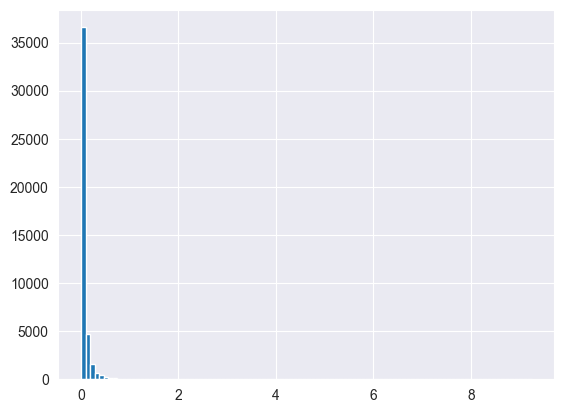

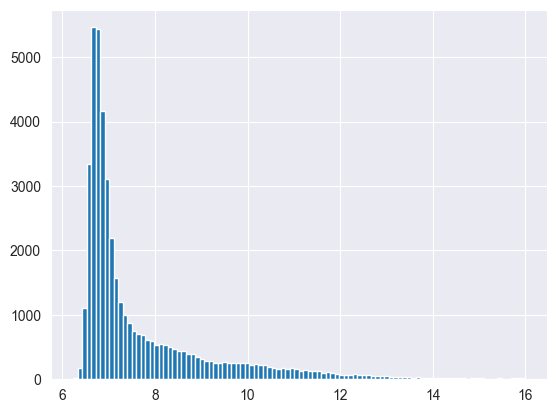

In [6]:
plt.hist(cell_mat.var(axis=1), bins=100)
plt.show()

plt.hist(cell_mat.max(axis=1), bins=100)
plt.show()

MAX_THRESH = {"Erythroid": 7.2, "Stem": 7.2}
VAR_THRESH = {"Erythroid": 0.3, "Stem": 0.25}

cell_mat = cell_mat[cell_mat.var(axis=1) > VAR_THRESH[CELL_TYPE]]
cell_mat = cell_mat[cell_mat.max(axis=1) > MAX_THRESH[CELL_TYPE]]

additional filtering

In [7]:
# find intersection strains of genotypes and cell_mat
cell_strains = np.intersect1d(genotypes.columns[3:], cell_mat.columns)
cell_mat = cell_mat[cell_strains]
cell_mat = cell_mat.groupby(cell_mat.index).mean()

# filter genotypes
cell_snps = genotypes[['Locus', 'Chr_Build37', 'Build37_position'] + list(cell_strains)]
cell_snps.set_index("Locus", inplace=True)
cell_snps = cell_snps.drop_duplicates()

# remove rows with values other than B or D
X = cell_snps[cell_snps.columns[2:]].map(lambda x: "B" if x == "B" else "D" if x == "D" else None)
cell_snps = cell_snps.loc[X.dropna().index]

Build37 metadata filtering

In [8]:
pd_meta = pd_meta[["marker symbol", "representative genome chromosome", 'representative genome start', 'representative genome end']]
pd_meta = pd_meta.dropna().reset_index(drop=True)
pd_meta.columns = ["expression", "chrom", "start", "end"]
pd_meta.set_index("expression", inplace=True)
pd_meta = pd_meta[~ (pd_meta["chrom"].isin(['MT','Y']))]

# filter genes that are not in pd_meta
genes_intersect = np.intersect1d(cell_mat.index, pd_meta.index)
pd_meta = pd_meta.loc[genes_intersect]
cell_mat = cell_mat.loc[genes_intersect]

save data

In [9]:
with open(f"./data/preprocessed_{CELL_TYPE}.pkl", "wb") as f:
    pickle.dump(cell_mat, f)
    pickle.dump(cell_snps, f)
    pickle.dump(pd_meta, f)